# Linear Models<br>and Generalized Linear Models


# Week 8 Homework

# Q1: derive the following

1. $p(\boldsymbol \beta | \textbf{y}, \textbf{X}, \Sigma=\sigma^2 I)$ for the **linear regression model** likelihood proportional to $\exp \left(-{\frac {1}{2}}(\mathbf {y} -\mathbf{X\boldsymbol \beta})^\top \Sigma^{-1}(\mathbf {y} - \mathbf{X\boldsymbol\beta})\right)$ and a $\mathcal{MVN}(\boldsymbol\beta_0, \boldsymbol\Sigma_\beta)$ for $\boldsymbol\beta$

2. The analytical posterior distribution for $\sigma^2$ the **error variance** of a **linear regression model** with **design matrix** $\mathbf{X}$ assuming $\sigma^2$ has an **inverse-gamma** prior distribution with parameters $\alpha^*$ and $\beta^*$ (unrelated to $\boldsymbol \beta$).

#### [Optional] Q1 Extra: derive the following

Show that for $s_i=1$ and **hyperparameters** $b_i=0$ (ignoring normalizing proportionality constants) the log posterior distributions for $\beta$ using either **normal** or **Laplace** prior distributions have analagous forms to the **ridge** and **lasso** loss functions.

*Note though that Bayesians do not optimize posterior distributions, they sample from them; but, nonetheless, the posterior distributions serve to provided 'regularizeations' of the likelihood through the prior.*

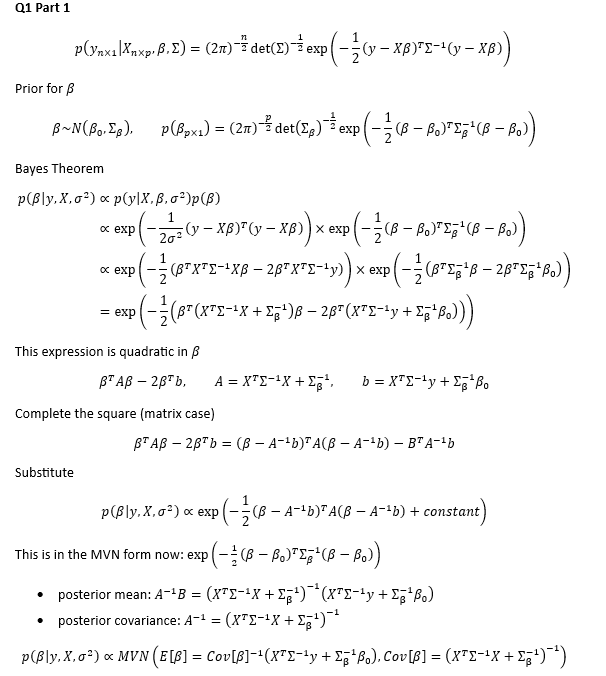

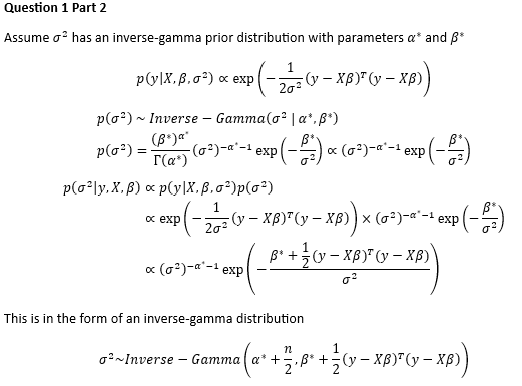

# Q2: perform Bayesian Linear Regression

- For any data set you find interesting (perhaps from kaggle.com?)
- Use an appropriate non **inverse-gamma** prior for `sigma` 
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than a `pm.MvNormal` alternative
- Use `pm.Normal('y', mu=X@betas, sigma=sigma, observed=y)` rather than `pm.MvNormal` alternative
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### [Optional] Q2 Extra: perform generalized Bayesian Linear Regression

Replace the residual distribution and use an appropriate link function

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

In [2]:
df = pd.read_csv('cleaned_imdb_2024.csv')
# df.head()


In [3]:
df_filtered = df.copy()

# filter so Budget and Revenue is 1M+ and Vote Count is 1K+
df_filtered = df_filtered[df_filtered['Budget_USD'].str.contains('M$', na=False)]
df_filtered = df_filtered[df_filtered['Revenue_$'].str.contains('M$', na=False)]
df_filtered = df_filtered[df_filtered['Vote_Count'].str.contains('K$', na=False)]

# convert to numeric
df_filtered['Budget_USD'] = df_filtered['Budget_USD'].replace({'\$': '', 'M': ''}, regex=True).astype(float)
df_filtered['Revenue_$'] = df_filtered['Revenue_$'].replace({'\$': '', 'M': ''}, regex=True).astype(float)
df_filtered['Vote_Count'] = df_filtered['Vote_Count'].str.replace('K', '').astype(float)

df_display = df_filtered[['Movie_Name', 'Vote_Average', 'Budget_USD', 'Revenue_$']].copy()
df_display = df_display.rename(columns={
    'Vote_Count': 'Vote_Count (K)', 
    'Budget_USD': 'Budget_USD (M)',
    'Revenue_$': 'Revenue_$ (M)'
})

df_display.head()

,Movie_Name,Vote_Average,Budget_USD (M),Revenue_$ (M)
0,Nosferatu,7.3,50.0,176.0
1,Emilia Pérez,5.5,27.3,15.0
2,The Brutalist,7.9,10.0,31.1
3,Saturday Night,7.0,25.0,10.0
4,The Substance,7.3,17.5,77.0


In [25]:
X = df_filtered[['Vote_Average', 'Budget_USD']].values  # predictors beta1, beta2
y = df_filtered['Revenue_$'].values  # target variable

X = np.column_stack([np.ones(X.shape[0]), X])  # Add intercept term

with pm.Model() as model:
    # Priors for betas 
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X.shape[1])
    
    # HalfNormal prior for sigma )
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Likelihood (Normal distribution for y)
    y_obs = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

In [26]:
with model:
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [31]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.259,0.983,-1.457,2.245,0.018,0.015,3125.0,2658.0,1.0
betas[1],3.221,0.658,2.016,4.439,0.011,0.008,3522.0,3072.0,1.0
betas[2],1.877,0.056,1.772,1.981,0.001,0.001,3525.0,2942.0,1.0
sigma,38.332,0.494,37.450,39.276,0.008,0.006,3889.0,2918.0,1.0


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

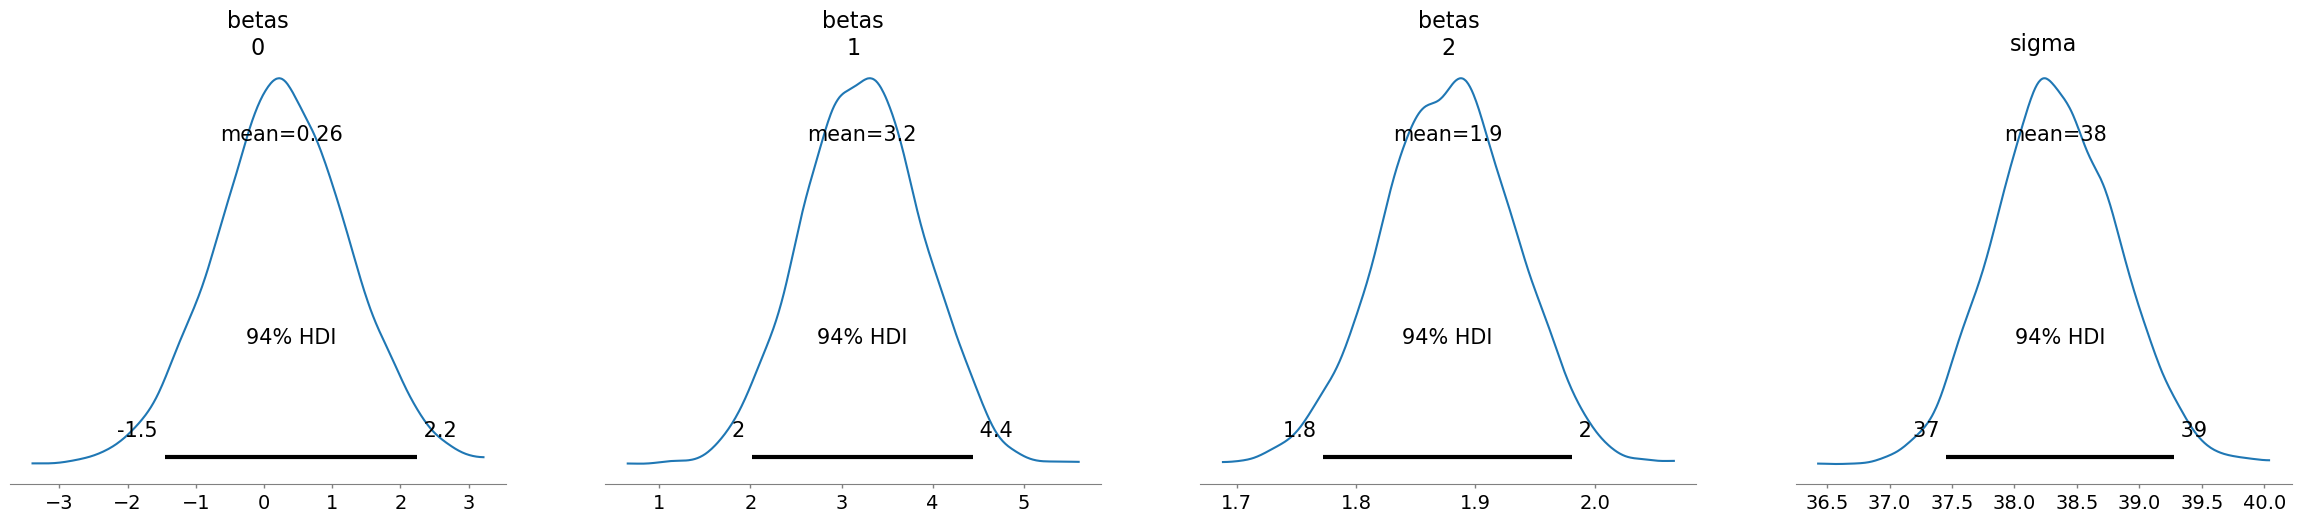

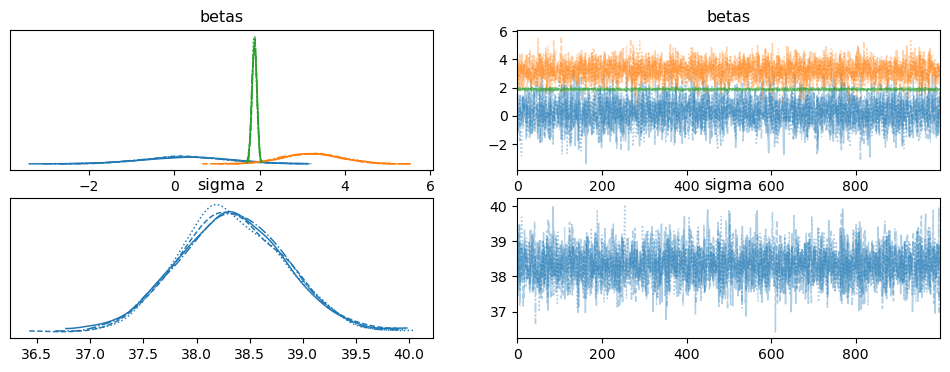

In [33]:
# Posterior distributions
az.plot_posterior(idata, var_names=['betas', 'sigma'])

# Trace plots
az.plot_trace(idata, var_names=['betas', 'sigma'])

# Pairplot (to visualize relationships between different variables in the posterior)
# az.plot_pair(idata, var_names=['betas', 'sigma'])

### Data
I extracted the cleaned_imdb_2024 data from kaggle https://www.kaggle.com/datasets/sanadalali/imdb-2024-movies-and-tv-shows?resource=download

Predictors:
* beta0: intercept
* beta1: Vote_Average
* beta2: Budget_USD

Target: Revenue_$

### Provide inference with Bayesian posterior analysis and report MCMC diagnostics

Beta0 (intercept): mean=0.259, HDI= [-1.457, 2.245]
* Close to zero: close to no revenue when predictors are 0

Beta1 (Vote_Average): mean=3.221, HDI= [2.016, 4.439]
* positive effect on revenue: movies with higher ratings earn more revenue
* HDI interval is above 0 - strong predictor
* for every 1 point increase in Vote_Average, the revenue increases by 3.22M

Beta2 (Budget_USD): mean=1.877, HDI= [1.772, 1.981]
* positive effect on revenue: movies with higher budgets earn more revenue
* HDI is very narrow - high confidence in estimate
* for every 1.0M increase in Budget_USD, the revenue increases by 1.877M

Sigma: 38.332, HDI=[37.450, 39.276]
* high standard deviation 
* model captures some revenue trends but lacks precision
* more predictors will improve accuracy

R_hat: 1.0 for all
* proper chain convergence for all

Effective Sample Size (ESS)
* ess_bulk and ess_tail are large: >3000 and >2600
* good number of independent samples were drawn

Monte Carlo Standard Error (MCSE)
* mcse_mean value is very low: estimated means of posterior distribution are stable and precise
* mcse_sd value is very low: spread/uncertainty of posterior distribution is reliable without significant sampling error


# Q3: perform robust Bayesian Linear Regression

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\boldsymbol \beta, \tau,\tau_i)$ be $\mathcal{N}(y_i | \textbf{X} \boldsymbol \beta, \overset{\textrm{precision}}{\tau \times \tau_i})$. 

- Return to your dataset and maniputate it to have some various outliers or find another dataset with some outlier data
- Use an appropriate prior for inference on $v$ if you have enough data to do so
- Use the posterior distributions of the $\tau_i$'s to identify data point "outliers" 
- Use the posterior distributions of the $\sigma_i^{-2} = \tau \times \tau_i$ to create posterior distribuitions of the **influence** (the diagonals of the $H$ "hat" matrix $X^\top (X^\top D X)^{-1} X$ where $D_{ij}=0$ and $D_{ii} = \sigma^2_i$) and compare and contras some example "outlier" versus "non outlier" data points

- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### [Optional] Q3 Extra: measurement error models?

What if $\textbf{x}_i = \textbf{x}_i^{true} + \eta_i, \eta_i \sim \mathcal{MVN}(\textbf{0}, \Sigma)$ for some kind of measurement error covariance structure $\Sigma$ and $\mathcal N (y_i| \textbf{X}^{true}\boldsymbol \beta, \sigma)$?

In [44]:
df_q3 = df_filtered.copy()

# Select 10 random indicies for outliers
outlier_indices = np.random.choice(df_q3.index, size=5, replace=False)

# Modify Revenue
df_q3.loc[outlier_indices[:3], 'Revenue_$'] *= 10  # Inflate revenue
df_q3.loc[outlier_indices[3:], 'Revenue_$'] /= 10  # Deflate revenue

# Modify Budget
df_q3.loc[outlier_indices[:3], 'Budget_USD'] *= 5  # Inflate budget
df_q3.loc[outlier_indices[3:], 'Budget_USD'] /= 5  # Deflate budget

# Modify Vote_Average
df_q3.loc[outlier_indices[:3], 'Vote_Average'] = 1  # Extremely low rating
df_q3.loc[outlier_indices[3:], 'Vote_Average'] = 9  # Extremely high rating


In [45]:
X = df_q3[['Vote_Average', 'Budget_USD']].values  # Predictors
y = df_q3['Revenue_$'].values  # Target variable

X = np.column_stack([np.ones(X.shape[0]), X])

with pm.Model() as robust_model:
    
    # Priors for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X.shape[1])

    #
    nu = pm.Exponential('nu', 1/10)  # Prior for Student-t degrees of freedom
    tau = pm.Gamma('tau', alpha=2, beta=2)  # Common precision
    tau_i = pm.Gamma('tau_i', alpha=nu/2, beta=nu/2, shape=y.shape[0])  # Per-data variance

    # Likelihood using Normal
    sigma_i = pm.Deterministic('sigma_i', (tau * tau_i) ** -0.5)  # Convert precision to std dev
    y_obs = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma_i, observed=y)


In [46]:
with robust_model:
    idata2 = pm.sample(2000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, nu, tau, tau_i]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [47]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.061,0.987,-1.842,1.910,0.011,0.011,8113.0,6073.0,1.00
betas[1],0.837,0.610,-0.252,2.035,0.009,0.007,4393.0,5414.0,1.00
betas[2],1.130,0.123,0.975,1.351,0.012,0.009,453.0,158.0,1.01
nu,0.866,0.162,0.589,1.193,0.007,0.005,440.0,395.0,1.01
sigma_i[0],167.663,285.160,30.383,405.599,6.047,4.277,4822.0,2528.0,1.00
...,...,...,...,...,...,...,...,...,...
tau_i[90],0.785,0.853,0.000,2.348,0.012,0.008,2985.0,3088.0,1.00
tau_i[91],2.096,2.211,0.000,6.000,0.023,0.018,5480.0,3072.0,1.00
tau_i[92],1.910,2.009,0.000,5.571,0.022,0.016,4924.0,2891.0,1.00
tau_i[93],2.123,2.298,0.001,6.215,0.024,0.019,5551.0,3041.0,1.00


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

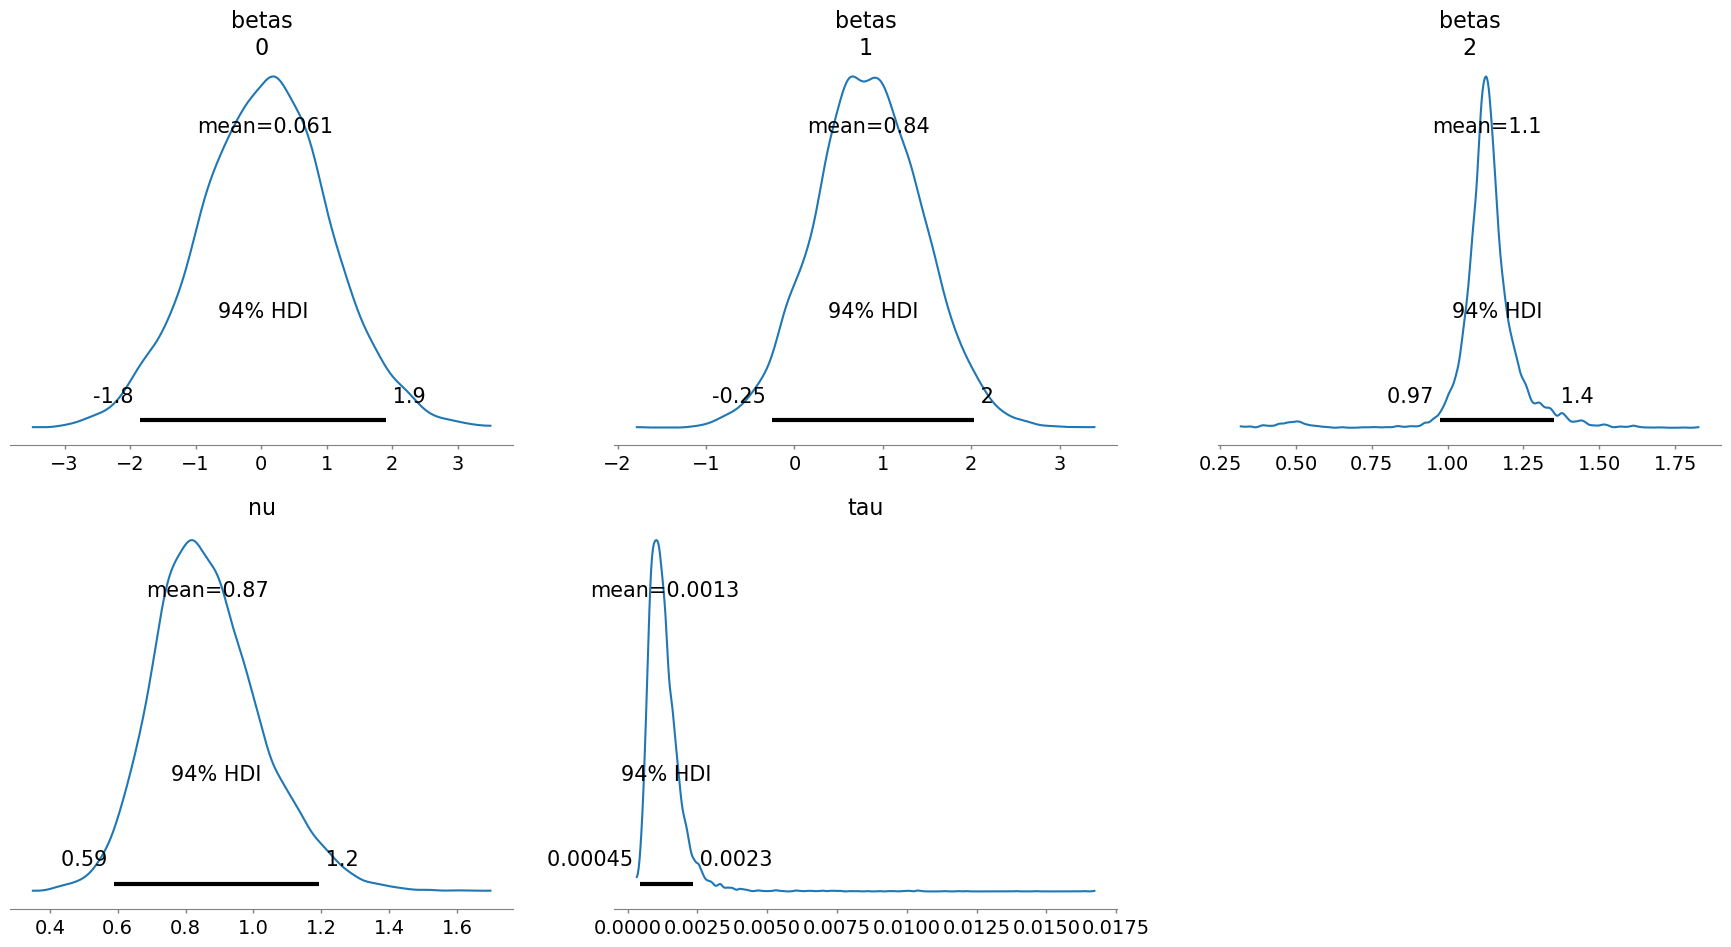

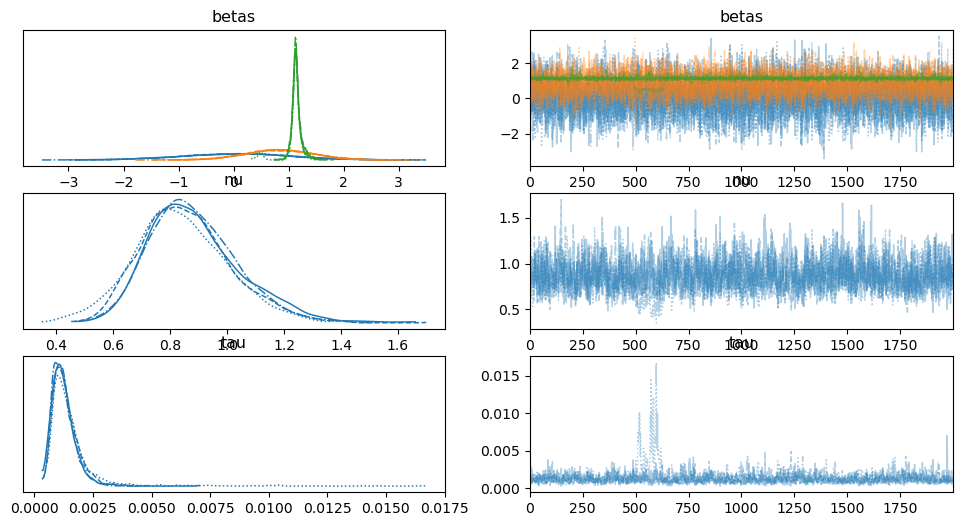

In [50]:
# Posterior distributions
az.plot_posterior(idata2, var_names=['betas', 'nu', 'tau'])

# Trace plots
az.plot_trace(idata2, var_names=['betas', 'nu', 'tau'])

# Pairplot (to visualize relationships between different variables in the posterior)
# az.plot_pair(idata, var_names=['betas', 'sigma'])

In [54]:
# 5 lowest tau_i values
tau_i_mean = idata2.posterior['tau_i'].mean(dim=['chain', 'draw'])
outlier_indices_detected = np.argsort(tau_i_mean)[:5]  # Sort and take the first 5

# Print detected outliers
print("data points: ", len(df_q3)) 
print("Detected Outlier Indices:", outlier_indices_detected)



data points:  95
Detected Outlier Indices: <xarray.DataArray 'tau_i' (tau_i_dim_0: 5)> Size: 40B
array([27, 61, 11, 22, 14])
Coordinates:
  * tau_i_dim_0  (tau_i_dim_0) int64 40B 0 1 2 3 4


In [55]:
# Compute influence scores 
XTX_inv = np.linalg.inv(X.T @ np.diag(tau_i_mean) @ X) # (X^T D X) ^-1
H = np.dot(X, XTX_inv @ X.T)
influence_scores = np.diag(H) 

print("Influence Scores of Outliers:", influence_scores[outlier_indices_detected])
print("Influence Scores of Normal Points:", influence_scores[np.setdiff1d(range(len(X)), outlier_indices_detected)])


Influence Scores of Outliers: [0.2203661  0.02026985 0.07736379 0.15690306 0.0892441 ]
Influence Scores of Normal Points: [0.02155875 0.01810596 0.02913439 0.01452272 0.01804112 0.13723357
 0.02463351 0.01183954 0.03364414 0.04130676 0.01967283 0.05613833
 0.27609752 0.01477023 0.01147749 0.02883942 0.02551265 0.01553277
 0.0147015  0.01505203 0.01811576 0.57610538 0.05132362 0.01121138
 0.02600611 0.08794458 0.01906152 0.018212   0.01403126 0.02722092
 0.03856239 0.01312078 0.01283288 0.02563926 0.05003252 0.02360895
 0.02563926 0.01588651 0.05938008 0.0331444  0.01284243 0.01225389
 0.03395789 0.02307133 0.01456815 0.01310964 0.01173815 0.01128501
 0.01110528 0.02297646 0.2647155  0.02422202 0.01323014 0.0255134
 0.01476118 0.06247402 0.03539685 0.03324125 0.01331262 0.03098013
 0.01928023 0.04835025 0.01535248 0.06849553 0.01346665 0.019711
 0.01225306 0.02962146 0.02291237 0.01746704 0.0671717  0.01183583
 0.04421887 0.01434168 0.01140275 0.06500826 0.0450176  0.01128501
 0.0136912

In [58]:
# Calculate statistics for outliers
outlier_mean = np.mean(influence_scores[outlier_indices_detected])
outlier_sd = np.std(influence_scores[outlier_indices_detected], ddof=1)
outlier_min = np.min(influence_scores[outlier_indices_detected])
outlier_max = np.max(influence_scores[outlier_indices_detected])

# Calculate statistics for normal points
normal_indices = np.setdiff1d(range(len(X)), outlier_indices_detected)
normal_mean = np.mean(influence_scores[normal_indices])
normal_sd = np.std(influence_scores[normal_indices], ddof=1)
normal_min = np.min(influence_scores[normal_indices])
normal_max = np.max(influence_scores[normal_indices])

# Print results
print(f"Outliers - Mean: {outlier_mean:.6f}, SD: {outlier_sd:.6f}")
print(f"Normal Points - Mean: {normal_mean:.6f}, SD: {normal_sd:.6f}")


Outliers - Mean: 0.112829, SD: 0.077279
Normal Points - Mean: 0.039134, SD: 0.070472


### Influence Scores of Outliers vs Normal Points
* mean for outliers influence is significantly higher at 0.11 compared to normal influence at 0.03
* similar standard deviation of data for both
* this indicates that outliers have more influence than normal points
* however some normal points have higher influence (0.576) and some outliers have lower influence (0.020)

### Provide inference with Bayesian posterior analysis and report MCMC diagnostics

Beta0 (intercept): mean=0.061, HDI= [-1.842, 1.910]
* Close to zero: close to no revenue when predictors are 0

Beta1 (Vote_Average): mean=0.837, HDI= [-0.252,	2.035]
* positive effect on revenue: movies with higher ratings earn more revenue
* HDI interval includes 0: uncertainty exists
* for every 1 point increase in Vote_Average, the revenue increases by 0.837M

Beta2 (Budget_USD): mean=1.130, HDI= [0.975	1.351]
* positive effect on revenue: movies with higher budgets earn more revenue
* HDI is very narrow - high confidence in estimate
* for every 1.0M increase in Budget_USD, the revenue increases by 1.351M

Nu (robust parameter): mean=0.866, HDI=[0.589, 1.193]
* low nu suggests heavy tailed residuals
* model is handling outliers effectively

Sigma: 167.166, HDI=[30.383, 405.599]
* very high standard deviation 
* model captures some revenue trends but lacks precision
* more predictors will improve accuracy

R_hat: 1.0-1.1 for all
* proper chain convergence for all

Effective Sample Size (ESS)
* beta0 and beta1 have large ess_bulk and ess_tail: >4000: good number of independent samples were drawn
* beta2 has low ess_bulk and ess_tail: 453 and 158
* sampler is not effectively exploring central part of beta2's posterior distribution
* uncertainty in extreme/tail values

Monte Carlo Standard Error (MCSE)
* for betas including beta2:
* mcse_mean value is very low: estimated means of posterior distribution are stable and precise
* mcse_sd value is very low: spread/uncertainty of posterior distribution is reliable without significant sampling error

Outlier Identification (tau_i values)
* low tau_i values (near 0.0) suggest potential outliers.
* some tau_i values have high variance: model is allowing flexible variance for indiv data points, making it robust to outliers.
